In [19]:
import pandas as pd
import numpy as np

In [20]:
df = pd.read_csv("delta.csv")

Pearson 상관계수

In [21]:
from scipy.stats import pearsonr

r, p_value = pearsonr(df["delta_train"], df["delta_essay"])
print("Pearson r:", r)
print("p-value:", p_value)

Pearson r: 0.9716932974554527
p-value: 5.5506240979836326e-05


Spearman 상관계수

In [22]:
from scipy.stats import spearmanr

rho, p_spear = spearmanr(df["delta_train"], df["delta_essay"])
print("Spearman rho:", rho)
print("p-value:", p_spear)

Spearman rho: 1.0
p-value: 0.0


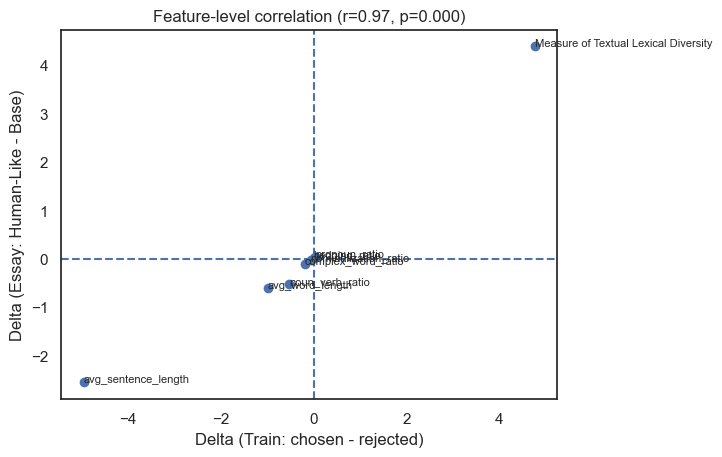

In [23]:
import matplotlib.pyplot as plt

plt.scatter(df["delta_train"], df["delta_essay"])

for i, row in df.iterrows():
    plt.text(row["delta_train"], row["delta_essay"], row["feature_name"], fontsize=8)

plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")

plt.xlabel("Delta (Train: chosen - rejected)")
plt.ylabel("Delta (Essay: Human-Like - Base)")
plt.title(f"Feature-level correlation (r={r:.2f}, p={p_value:.3f})")

plt.show()

회귀분석

In [24]:
import statsmodels.api as sm
import pandas as pd

X = df["delta_train"]
y = df["delta_essay"]

# 절편 포함
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            delta_essay   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     101.5
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           5.55e-05
Time:                        16:53:26   Log-Likelihood:                -4.5809
No. Observations:                   8   AIC:                             13.16
Df Residuals:                       6   BIC:                             13.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2479      0.176      1.408      

C:\Users\strow\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


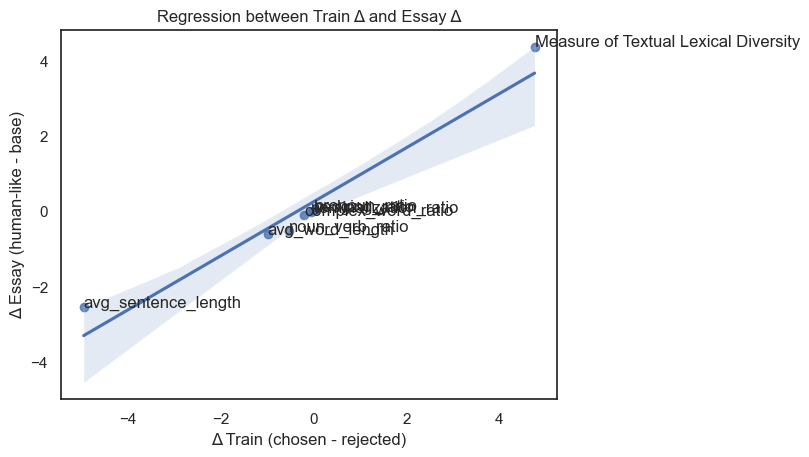

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x=df["delta_train"], y=df["delta_essay"])
plt.xlabel("Δ Train (chosen - rejected)")
plt.ylabel("Δ Essay (human-like - base)")
plt.title("Regression between Train Δ and Essay Δ")

for i, row in df.iterrows():
    plt.text(row["delta_train"], row["delta_essay"], row["feature_name"])
    

plt.show()

PCA - 시각화

In [26]:
cft = pd.read_csv("final_data_cft.csv")
dpo = pd.read_csv("final_data_dpo.csv")
chosen = pd.read_csv("final_data_chosen.csv")
rejected = pd.read_csv("final_data_rejected.csv")
human = pd.read_csv("final_data_human.csv")

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import ttest_rel


# Data 준비

X_train = pd.concat([chosen, rejected], axis=0).reset_index(drop=True)
y_train = np.array([1]*len(chosen) + [0]*len(rejected))


# Train dataset Standardization

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA fitting (train data)

pca = PCA(n_components=1)  # PC1만 추출
train_pc1 = pca.fit_transform(X_train_scaled).flatten()

print("Explained variance (PC1):", pca.explained_variance_ratio_[0])

# chosen vs rejected의 PC1 평균 비교
pc1_chosen = train_pc1[y_train == 1]
pc1_rejected = train_pc1[y_train == 0]

print("Chosen mean PC1:", pc1_chosen.mean())
print("Rejected mean PC1:", pc1_rejected.mean())

t_stat, p_val = ttest_rel(pc1_chosen[:len(pc1_rejected)], pc1_rejected)
print("Train PC1 paired t-test p-value:", p_val)

# Essay dataset 변환 (train scaler + train PCA 사용)

X_base_scaled = scaler.transform(cft)
X_human_scaled = scaler.transform(dpo)

essay_pc1_base = pca.transform(X_base_scaled).flatten()
essay_pc1_human = pca.transform(X_human_scaled).flatten()

print("Essay Base PC1 mean:", essay_pc1_base.mean())
print("Essay Human PC1 mean:", essay_pc1_human.mean())

t_stat2, p_val2 = ttest_rel(essay_pc1_human, essay_pc1_base)
print("Essay PC1 paired t-test p-value:", p_val2)
print("Delta Essay PC1:", essay_pc1_human.mean() - essay_pc1_base.mean())

Explained variance (PC1): 0.49977563920647844
Chosen mean PC1: -1.6141409390736068
Rejected mean PC1: 1.6141409390736068
Train PC1 paired t-test p-value: 0.0
Essay Base PC1 mean: 3.1546178734013934
Essay Human PC1 mean: 1.2419314307118163
Essay PC1 paired t-test p-value: 9.36681735271941e-68
Delta Essay PC1: -1.912686442689577


1차원 PCA - 설명력 44.82%

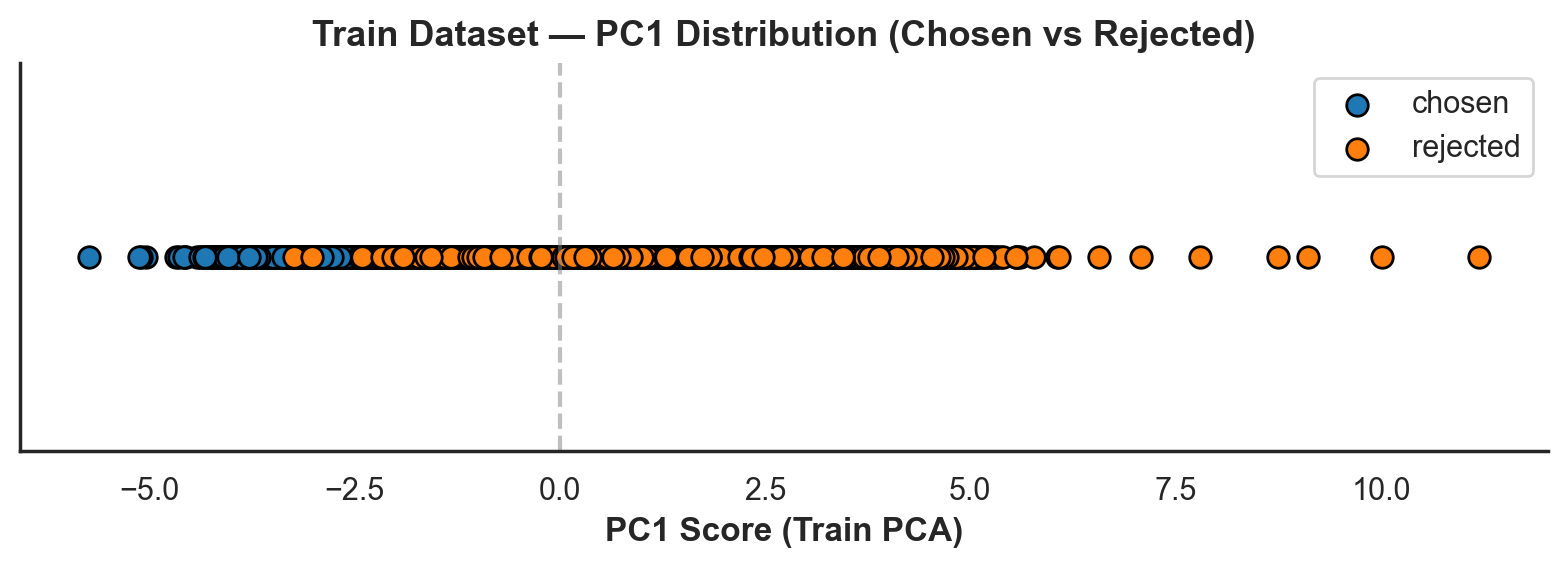

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# train_pc1 = PCA 결과에서 나온 PC1 점수 전체 (chosen+rejected)
# y_train = 1 (chosen), 0 (rejected)

pc1_chosen = train_pc1[y_train == 1]
pc1_rejected = train_pc1[y_train == 0]

plt.figure(figsize=(8, 3), dpi=200)
sns.set(style="white")

# chosen (왼쪽)
plt.scatter(pc1_chosen, 
            [0]*len(pc1_chosen), 
            color="#1f77b4", 
            s=60, edgecolor="black", label="chosen")

# rejected (오른쪽)
plt.scatter(pc1_rejected, 
            [0]*len(pc1_rejected), 
            color="#ff7f0e",
            s=60, edgecolor="black", label="rejected")

plt.axvline(0, linestyle='--', color='gray', alpha=0.5)

plt.yticks([])
plt.xlabel("PC1 Score (Train PCA)", fontsize=12, weight="bold")
plt.title("Train Dataset — PC1 Distribution (Chosen vs Rejected)", fontsize=13, weight="bold")
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


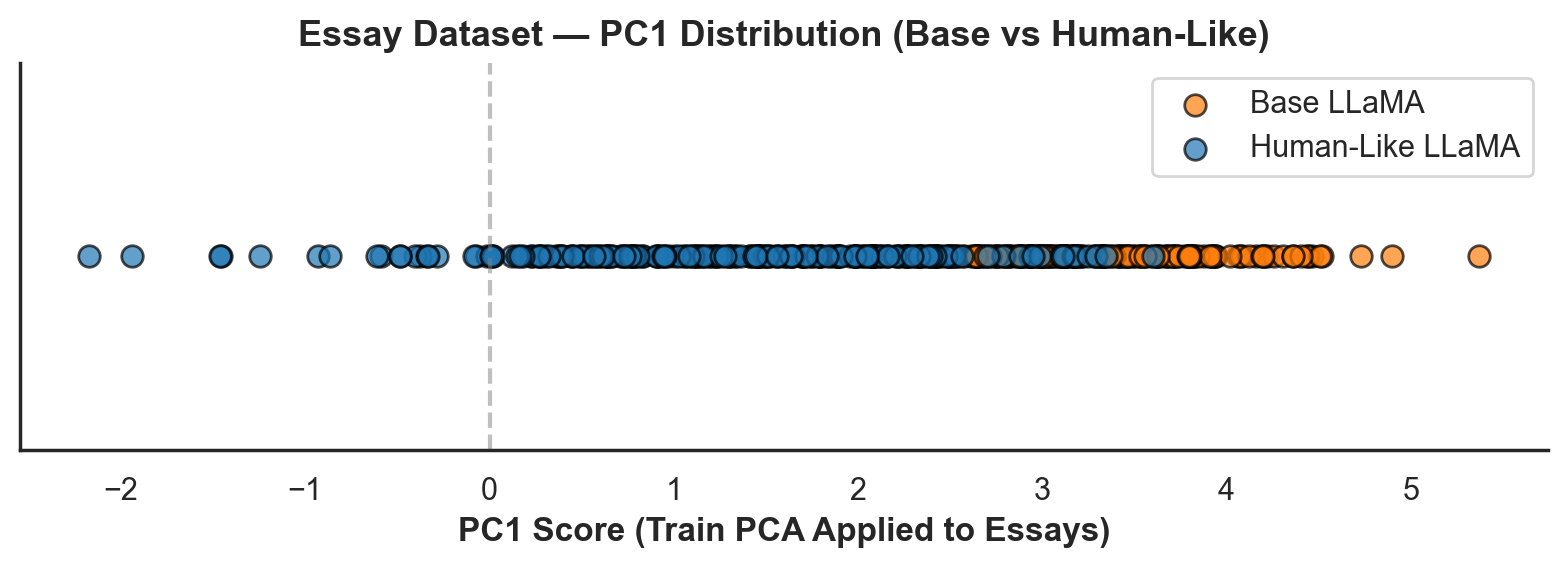

In [29]:
plt.figure(figsize=(8, 3), dpi=200)
sns.set(style="white")

# essay_pc1_base, essay_pc1_human은 PCA transform 결과
plt.scatter(essay_pc1_base, 
            [0]*len(essay_pc1_base),
            color="#ff7f0e",
            s=60, edgecolor="black", alpha=0.7, label="Base LLaMA")

plt.scatter(essay_pc1_human, 
            [0]*len(essay_pc1_human),
            color="#1f77b4",
            s=60, edgecolor="black", alpha=0.7, label="Human-Like LLaMA")

plt.axvline(0, linestyle='--', color='gray', alpha=0.5)

plt.yticks([])
plt.xlabel("PC1 Score (Train PCA Applied to Essays)", fontsize=12, weight="bold")
plt.title("Essay Dataset — PC1 Distribution (Base vs Human-Like)", fontsize=13, weight="bold")
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


2차원 PCA - 시각화

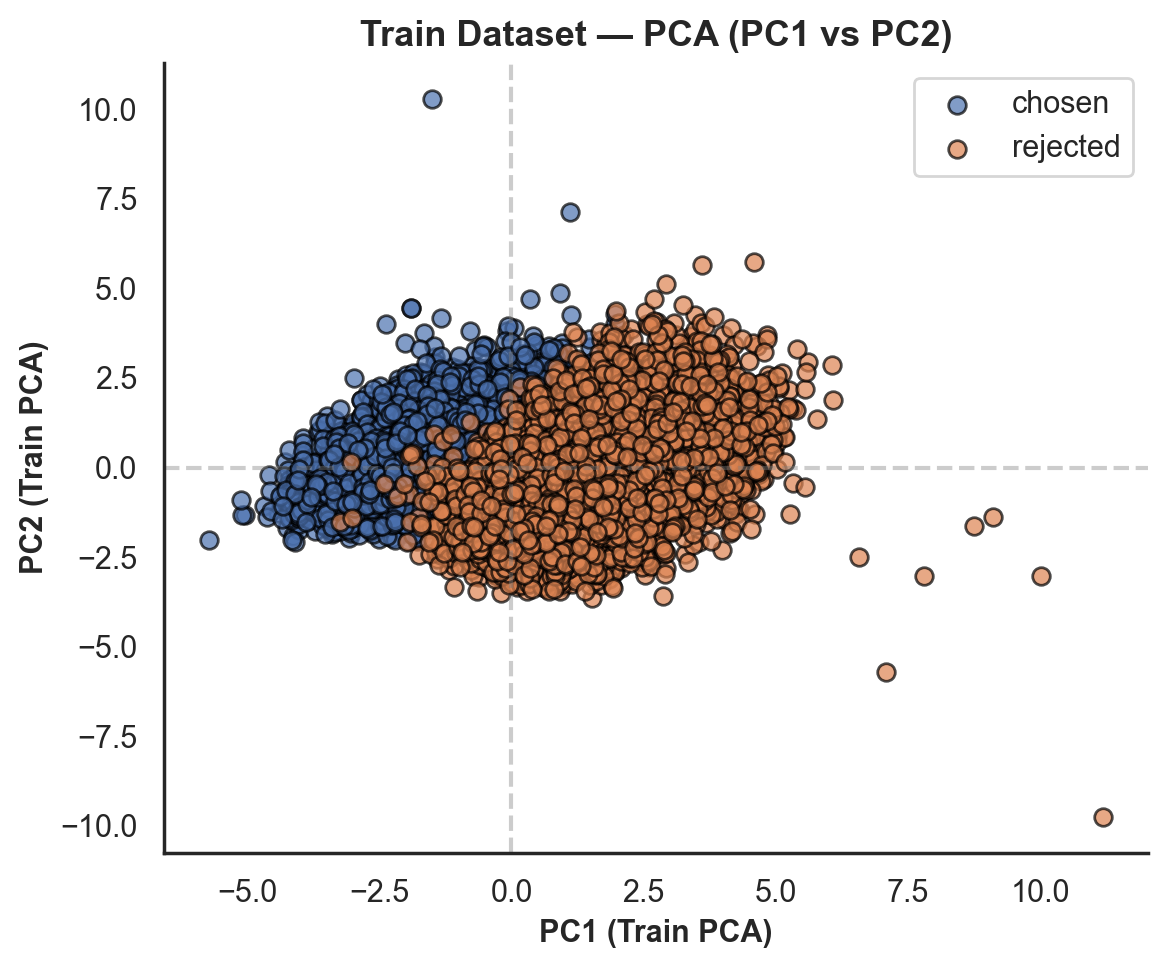

In [30]:
X_train = pd.concat([chosen, rejected], axis=0).reset_index(drop=True)
y_train = np.array([1]*len(chosen) + [0]*len(rejected))  # 1=chosen, 0=rejected

# Standardization

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA (2 components)

pca2 = PCA(n_components=2)
train_pc = pca2.fit_transform(X_train_scaled)   # shape: (n_samples, 2)

pc1 = train_pc[:, 0]
pc2 = train_pc[:, 1]

# 2D scatter plot (Train)

plt.figure(figsize=(6, 5), dpi=200)
sns.set(style="white")

plt.scatter(pc1[y_train==1], pc2[y_train==1],
            s=40, edgecolor="black", alpha=0.7,
            label="chosen")

plt.scatter(pc1[y_train==0], pc2[y_train==0],
            s=40, edgecolor="black", alpha=0.7,
            label="rejected")

plt.axvline(0, linestyle="--", color="gray", alpha=0.4)
plt.axhline(0, linestyle="--", color="gray", alpha=0.4)

plt.xlabel("PC1 (Train PCA)", fontsize=11, weight="bold")
plt.ylabel("PC2 (Train PCA)", fontsize=11, weight="bold")
plt.title("Train Dataset — PCA (PC1 vs PC2)", fontsize=13, weight="bold")
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

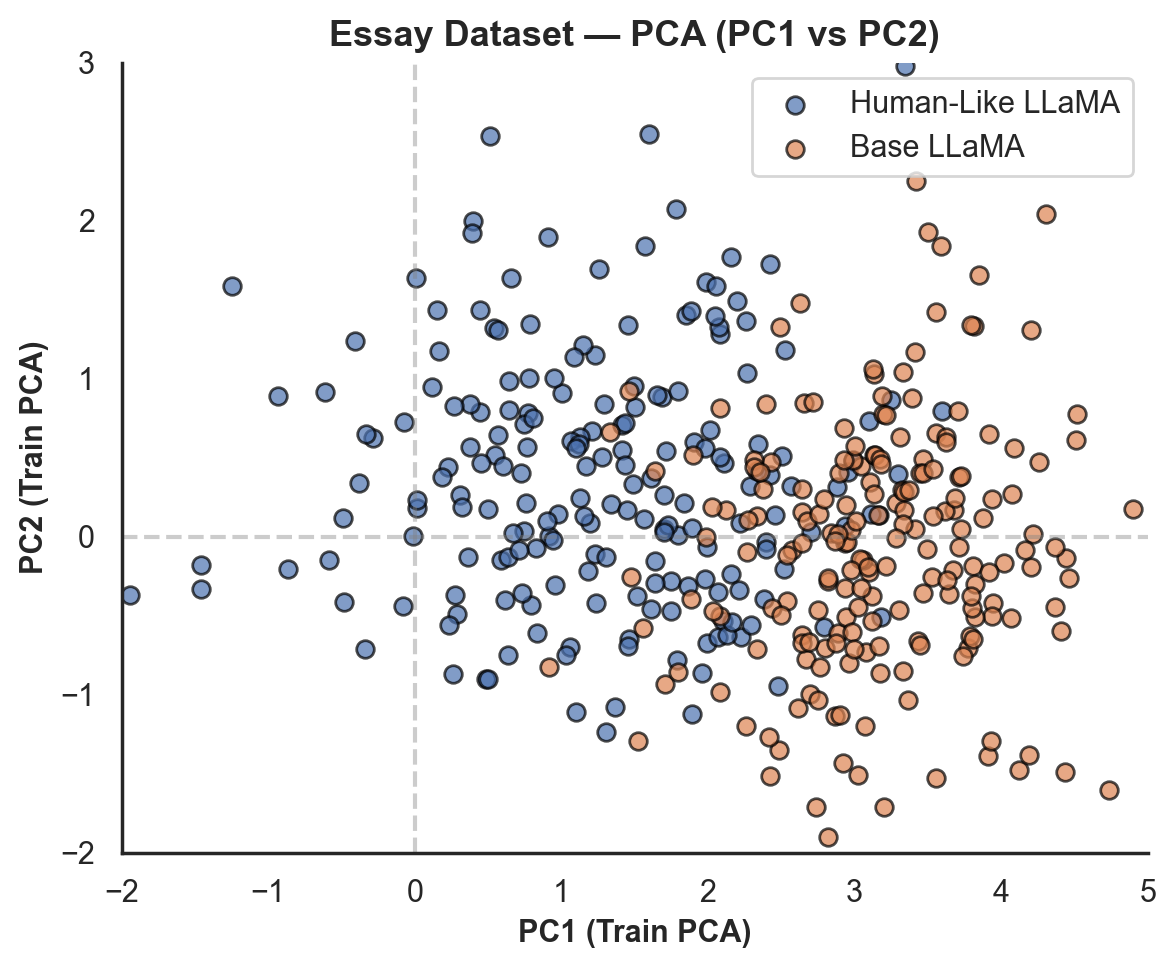

In [35]:
X_base_scaled  = scaler.transform(cft)
X_human_scaled = scaler.transform(dpo)

essay_pc_base  = pca2.transform(X_base_scaled)   # (n_base, 2)
essay_pc_human = pca2.transform(X_human_scaled)  # (n_human, 2)

pc1_base,  pc2_base  = essay_pc_base[:, 0],  essay_pc_base[:, 1]
pc1_human, pc2_human = essay_pc_human[:, 0], essay_pc_human[:, 1]

# 2D scatter plot (Essay)

plt.figure(figsize=(6, 5), dpi=200)
sns.set(style="white")

plt.scatter(pc1_human, pc2_human,
            s=40, edgecolor="black", alpha=0.7,
            label="Human-Like LLaMA")

plt.scatter(pc1_base, pc2_base,
            s=40, edgecolor="black", alpha=0.7,
            label="Base LLaMA")


plt.axvline(0, linestyle="--", color="gray", alpha=0.4)
plt.axhline(0, linestyle="--", color="gray", alpha=0.4)

plt.xlabel("PC1 (Train PCA)", fontsize=11, weight="bold")
plt.ylabel("PC2 (Train PCA)", fontsize=11, weight="bold")
plt.title("Essay Dataset — PCA (PC1 vs PC2)", fontsize=13, weight="bold")
plt.legend()
sns.despine()
plt.tight_layout()
plt.xlim(-2, 5)
plt.ylim(-2, 3)
plt.show()

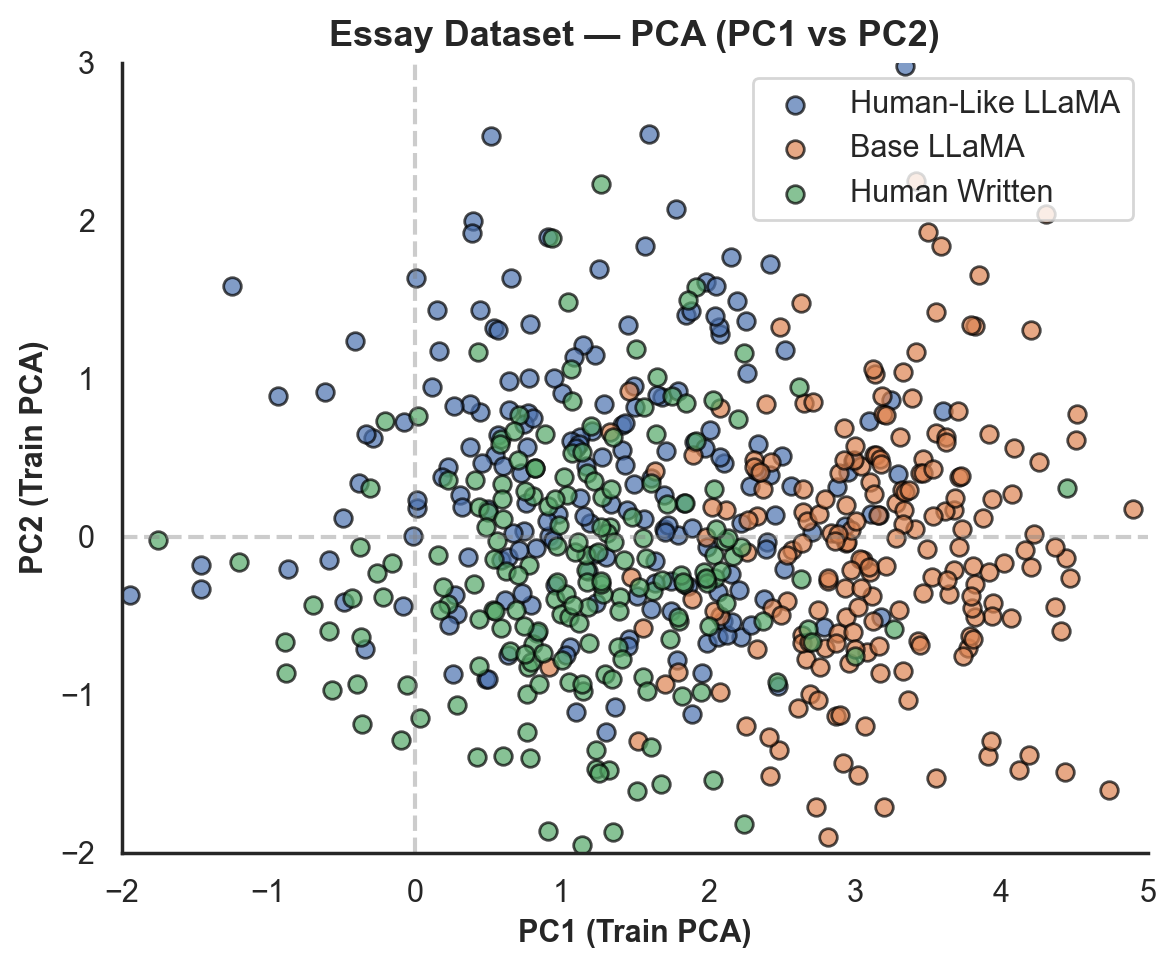

In [36]:
X_base_scaled  = scaler.transform(cft)
X_human_scaled = scaler.transform(dpo)
X_human_written = scaler.transform(human)

essay_pc_base  = pca2.transform(X_base_scaled)   # (n_base, 2)
essay_pc_human = pca2.transform(X_human_scaled)  # (n_human, 2)
essay_human_written = pca2.transform(X_human_written)

pc1_base,  pc2_base  = essay_pc_base[:, 0],  essay_pc_base[:, 1]
pc1_human, pc2_human = essay_pc_human[:, 0], essay_pc_human[:, 1]
pc1_human_written, pc2_human_written = essay_human_written[:, 0], essay_human_written[:, 1]

# 2D scatter plot (Essay)

plt.figure(figsize=(6, 5), dpi=200)
sns.set(style="white")

plt.scatter(pc1_human, pc2_human,
            s=40, edgecolor="black", alpha=0.7,
            label="Human-Like LLaMA")

plt.scatter(pc1_base, pc2_base,
            s=40, edgecolor="black", alpha=0.7,
            label="Base LLaMA")

plt.scatter(pc1_human_written, pc2_human_written,
            s=40, edgecolor="black", alpha=0.7,
            label="Human Written")


plt.axvline(0, linestyle="--", color="gray", alpha=0.4)
plt.axhline(0, linestyle="--", color="gray", alpha=0.4)

plt.xlabel("PC1 (Train PCA)", fontsize=11, weight="bold")
plt.ylabel("PC2 (Train PCA)", fontsize=11, weight="bold")
plt.title("Essay Dataset — PCA (PC1 vs PC2)", fontsize=13, weight="bold")
plt.legend()
sns.despine()
plt.tight_layout()
plt.xlim(-2, 5)
plt.ylim(-2, 3)
plt.show()

In [44]:
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv, norm

# 1. 데이터 로드 (파일 경로는 환경에 맞게 수정)
df_cft = pd.read_csv('final_data_cft.csv')          # Base Model
df_dpo = pd.read_csv('final_data_dpo.csv')          # Human-Like Model (DPO)
df_rejected = pd.read_csv('final_data_rejected.csv')
df_chosen = pd.read_csv('final_data_chosen.csv')
df_human = pd.read_csv('final_data_human.csv')

# 2. 공통 Feature 추출 (수치형 데이터만)
common_cols = list(set(df_cft.columns) & set(df_dpo.columns) & 
                   set(df_rejected.columns) & set(df_chosen.columns))
numeric_cols = df_cft[common_cols].select_dtypes(include=['number']).columns.tolist()
numeric_cols.sort() # Feature 순서 통일

# 3. 각 그룹의 평균 벡터 (Centroid) 계산
mu_cft = df_cft[numeric_cols].mean().values
mu_dpo = df_dpo[numeric_cols].mean().values
mu_rejected = df_rejected[numeric_cols].mean().values
mu_chosen = df_chosen[numeric_cols].mean().values
mu_human = df_human[numeric_cols].mean().values

# --- 분석 1: 벡터 코사인 유사도 (Vector Cosine Similarity) ---
# 방향성 벡터 정의
vec_human_pref = mu_chosen - mu_rejected  # 인간 선호 방향 (Target Direction)
vec_model_shift = mu_dpo - mu_cft         # 모델 변화 방향 (Actual Shift)

# 코사인 유사도 계산: (A . B) / (|A| * |B|)
cosine_sim = np.dot(vec_human_pref, vec_model_shift) / (norm(vec_human_pref) * norm(vec_model_shift))

print(f"=== Vector Cosine Similarity ===")
print(f"Cosine Similarity: {cosine_sim:.4f}")
print("-> 1에 가까울수록 모델이 인간 선호 방향과 일치하게 학습됨을 의미")


# --- 분석 2.1: 마할라노비스 거리 (Mahalanobis Distance) ---
# 분포의 기준: Chosen Data (도착하고자 하는 목표 지점의 분포)
cov_matrix = df_chosen[numeric_cols].cov()  # 공분산 행렬
inv_cov_matrix = inv(cov_matrix)            # 역행렬 (Inverse Covariance)

# 거리 계산
dist_cft = mahalanobis(mu_cft, mu_chosen, inv_cov_matrix)
dist_dpo = mahalanobis(mu_dpo, mu_chosen, inv_cov_matrix)

# 거리 감소율 (Ratio)
ratio = dist_dpo / dist_cft

print(f"\n=== Mahalanobis Distance to 'Chosen' Distribution ===")
print(f"Distance (CFT -> Chosen): {dist_cft:.4f}")
print(f"Distance (DPO -> Chosen): {dist_dpo:.4f}")

print(f"Reduction Ratio: {ratio:.4f}")
print(f"-> The distance decreased by {(1-ratio)*100:.1f}%, bringing the model closer to the chosen data distribution.")


# --- 분석 2.2: 마할라노비스 거리 (Mahalanobis Distance) ---
# 분포의 기준: Rejected Data (멀어지고자 하는 지점의 분포)
cov_matrix = df_rejected[numeric_cols].cov()  # 공분산 행렬
inv_cov_matrix = inv(cov_matrix)            # 역행렬 (Inverse Covariance)

# 거리 계산
dist_cft = mahalanobis(mu_cft, mu_rejected, inv_cov_matrix)
dist_dpo = mahalanobis(mu_dpo, mu_rejected, inv_cov_matrix)

# 거리 증가율 (Ratio)
ratio = dist_dpo / dist_cft

print(f"\n=== Mahalanobis Distance to 'Rejected' Distribution ===")
print(f"Distance (CFT -> Rejected): {dist_cft:.4f}")
print(f"Distance (DPO -> Rejected): {dist_dpo:.4f}")

print(f"Increase Ratio: {ratio:.4f}")
print(f"-> The distance increased by {(ratio-1)*100:.1f}%, bringing the model more far to the rejected data distribution.")


# --- 분석 2.3: 마할라노비스 거리 (Mahalanobis Distance) ---
# 분포의 기준: Human Data (도착하고자 하는 목표 지점의 분포)
cov_matrix = df_human[numeric_cols].cov()  # 공분산 행렬
inv_cov_matrix = inv(cov_matrix)            # 역행렬 (Inverse Covariance)

# 거리 계산
dist_cft = mahalanobis(mu_cft, mu_human, inv_cov_matrix)
dist_dpo = mahalanobis(mu_dpo, mu_human, inv_cov_matrix)

# 거리 감소율 (Ratio)
ratio = dist_dpo / dist_cft

print(f"\n=== Mahalanobis Distance to 'Human' Distribution ===")
print(f"Distance (CFT -> Human): {dist_cft:.4f}")
print(f"Distance (DPO -> Human): {dist_dpo:.4f}")

print(f"Reduction Ratio: {ratio:.4f}")
print(f"-> The distance decreased by {(1-ratio)*100:.1f}%, bringing the model closer to the chosen data distribution.")

=== Vector Cosine Similarity ===
Cosine Similarity: 0.9622
-> 1에 가까울수록 모델이 인간 선호 방향과 일치하게 학습됨을 의미

=== Mahalanobis Distance to 'Chosen' Distribution ===
Distance (CFT -> Chosen): 5.6207
Distance (DPO -> Chosen): 3.3360
Reduction Ratio: 0.5935
-> The distance decreased by 40.6%, bringing the model closer to the chosen data distribution.

=== Mahalanobis Distance to 'Rejected' Distribution ===
Distance (CFT -> Rejected): 2.1197
Distance (DPO -> Rejected): 2.6949
Increase Ratio: 1.2714
-> The distance increased by 27.1%, bringing the model more far to the rejected data distribution.

=== Mahalanobis Distance to 'Human' Distribution ===
Distance (CFT -> Human): 3.0624
Distance (DPO -> Human): 1.1095
Reduction Ratio: 0.3623
-> The distance decreased by 63.8%, bringing the model closer to the chosen data distribution.
